In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import obspy
import IPython.display as ipd
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from librosa.output import write_wav

In [2]:
# Initialize IRIS client
client = Client("IRIS")

# set our date range
starttime = UTCDateTime('2016-1-1')
endtime = UTCDateTime('2018-12-31')

POHA = client.get_stations(network="IU", station="POHA", 
                           starttime=starttime, endtime=endtime,
                          level='response')

In [9]:
cat = obspy.core.event.read_events("hawaii_2016-2018_mag3andabove_events.xml", format="QUAKEML") 

In [10]:
cat

3201 Event(s) in Catalog:
2018-12-30T00:58:25.890000Z | +19.337, -155.195 | 3.03 Ml
2018-12-21T00:20:08.360000Z | +19.321, -155.187 | 3.1 ML
...
2016-01-13T23:27:17.230000Z | +19.353, -155.082 | 3.3 ML
2016-01-03T16:47:07.670000Z | +19.394, -155.250 | 3.44 ml
To see all events call 'print(CatalogObject.__str__(print_all=True))'

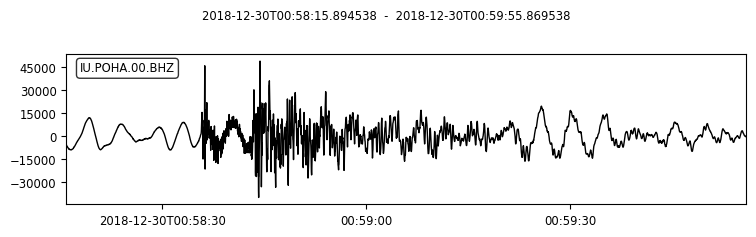

In [35]:
t1 = cat[0].origins[0].time
tr = client.get_waveforms(network='IU', station='POHA', location='00',
                               channel='BHZ', starttime=t1-10, endtime=t1+90,
                               attach_response=True)
_ = tr[0].plot()

In [36]:
copy = tr
copy.remove_response(POHA)#, output='DISP')#, pre_filt=pre_filt)

1 Trace(s) in Stream:
IU.POHA.00.BHZ | 2018-12-30T00:58:15.894538Z - 2018-12-30T00:59:55.869538Z | 40.0 Hz, 4000 samples

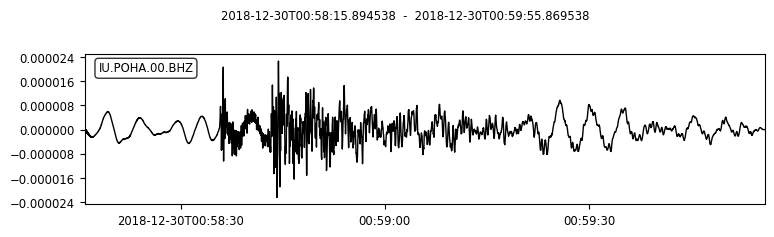

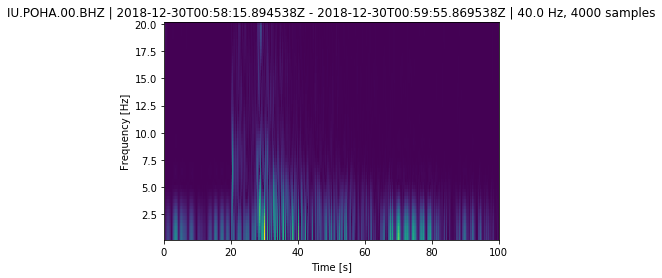

In [37]:
_ = copy[0].plot()
_ = copy[0].spectrogram()

In [38]:
filtered = copy
filtered.filter('highpass', freq=1.0, corners=2, zerophase=True)

1 Trace(s) in Stream:
IU.POHA.00.BHZ | 2018-12-30T00:58:15.894538Z - 2018-12-30T00:59:55.869538Z | 40.0 Hz, 4000 samples

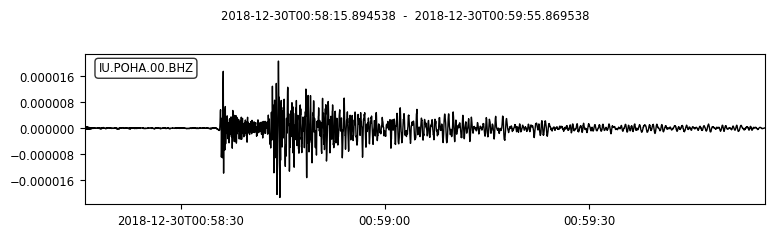

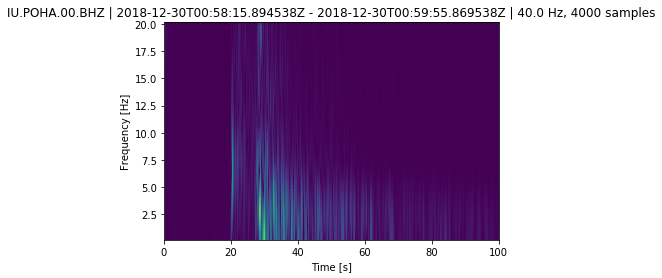

In [39]:
_ = filtered.plot()
_ = filtered.spectrogram()

In [48]:
write_wav('mag3_sample.wav', filtered[0].data*1e4, sr=2000)

In [49]:
ipd.Audio('mag3_sample.wav')

## Download seismograms for the whole catalog

In [ ]:
traces = list()

for event in cat:
    t = event.origins[0].time
    trace = client.get_waveforms(network='IU', station='POHA', location='00',
                               channel='BHZ', starttime=t-10, endtime=t+180,
                               attach_response=True)
    traces.append(trace[0])
    print("downloaded {}".format(trace))
    #trace.remove_response(POHA)
    #trace.filter('highpass', freq=1.0, corners=2, zerophase=True)

In [69]:
quakestream = obspy.Stream(traces=[x[0] for x in traces])
quakestream.write("hawaii_2016-2018_mag3_POHA_waveforms.mseed", format="MSEED") 

In [4]:
quakestream

3201 Trace(s) in Stream:

IU.POHA.00.BHZ | 2018-12-30T00:58:15.894538Z - 2018-12-30T01:01:25.869538Z | 40.0 Hz, 7600 samples
...
(3199 other traces)
...
IU.POHA.00.BHZ | 2016-01-03T16:46:57.719536Z - 2016-01-03T16:50:07.669536Z | 20.0 Hz, 3800 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [4]:
quakestream = obspy.read("hawaii_2016-2018_mag3_POHA_waveforms.mseed", format="MSEED")

In [5]:
quakestream.remove_response(POHA)
quakestream.filter('highpass', freq=1.0, corners=2, zerophase=True)

3201 Trace(s) in Stream:

IU.POHA.00.BHZ | 2018-12-30T00:58:15.894538Z - 2018-12-30T01:01:25.869538Z | 40.0 Hz, 7600 samples
...
(3199 other traces)
...
IU.POHA.00.BHZ | 2016-01-03T16:46:57.719536Z - 2016-01-03T16:50:07.669536Z | 20.0 Hz, 3800 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

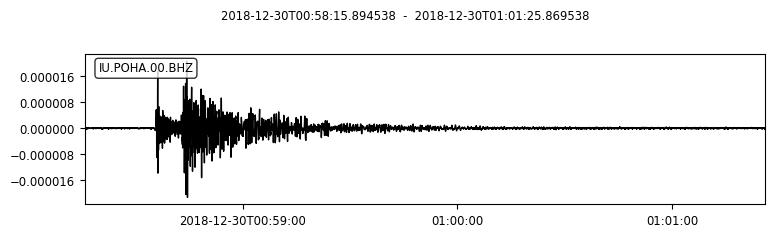

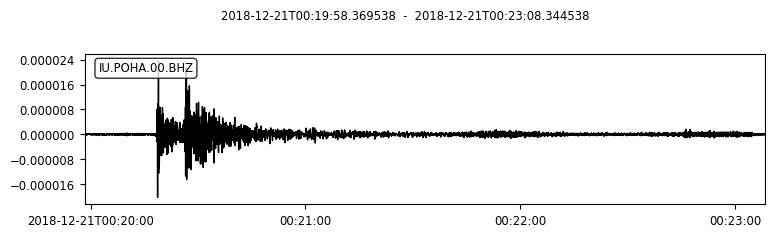

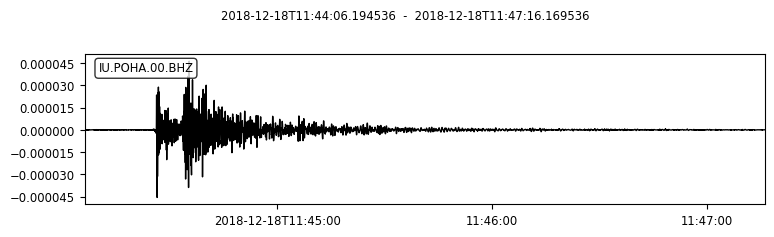

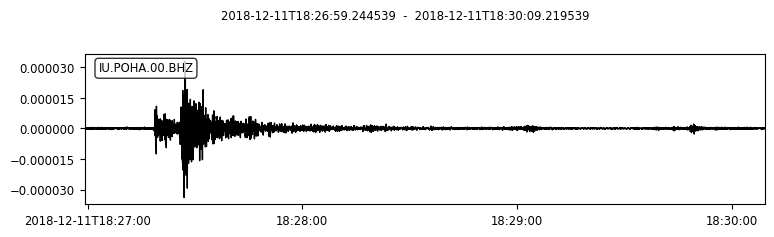

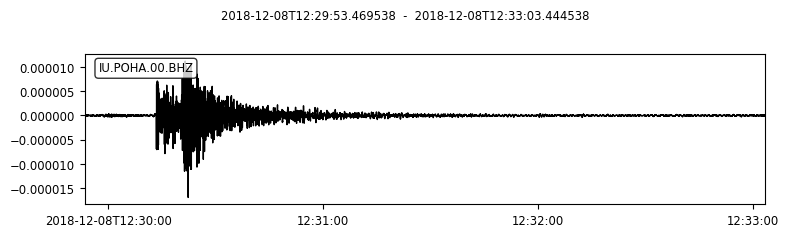

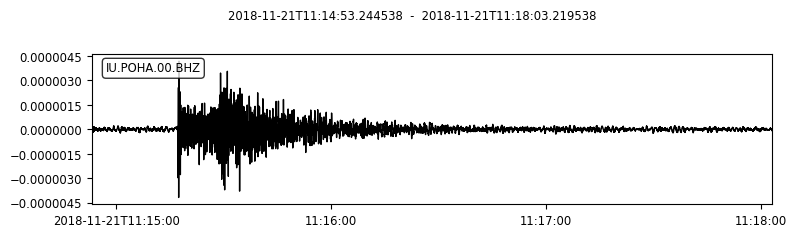

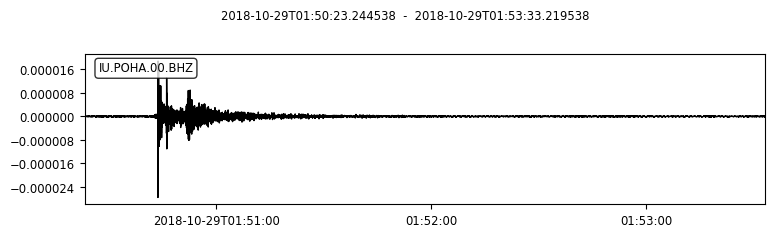

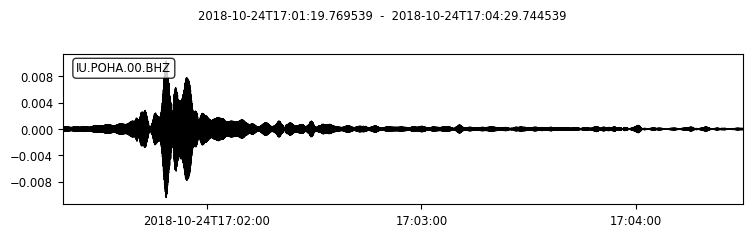

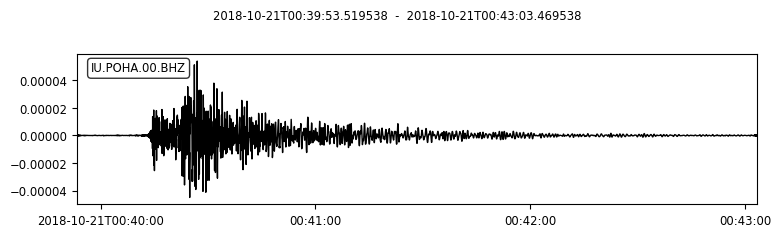

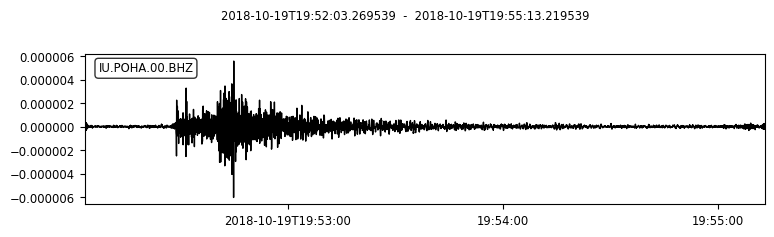

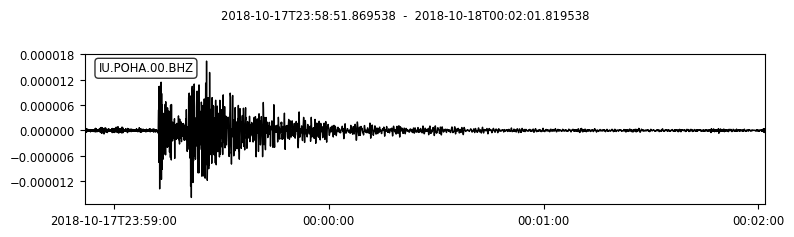

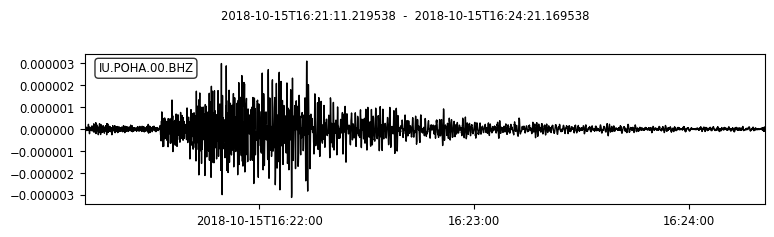

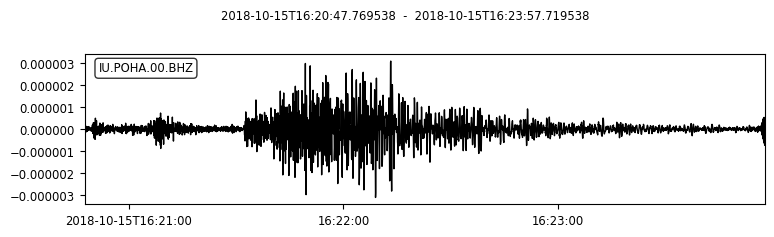

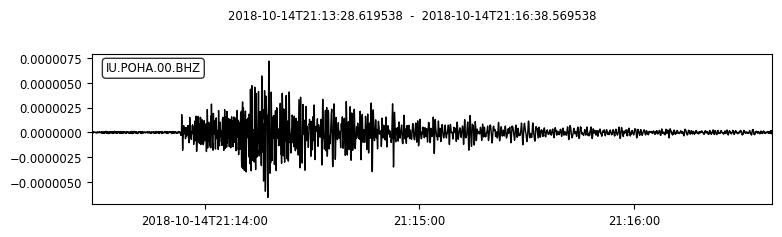

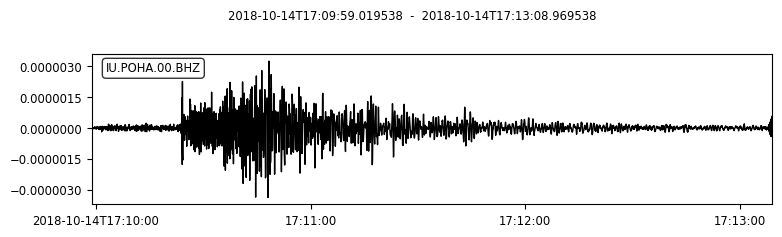

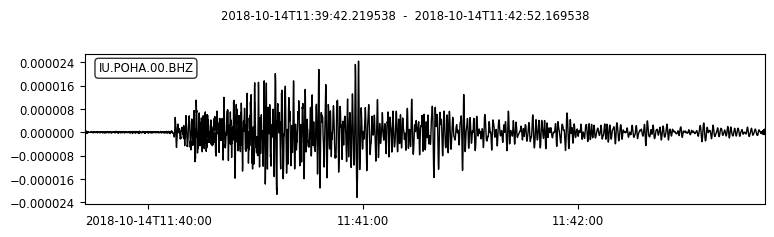

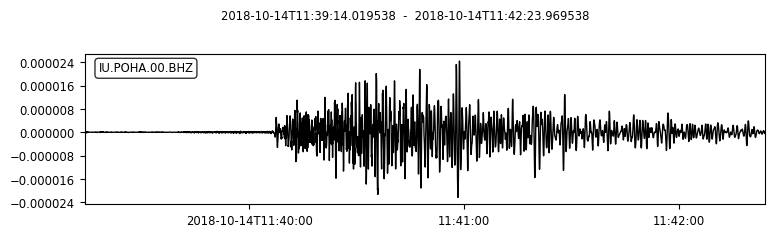

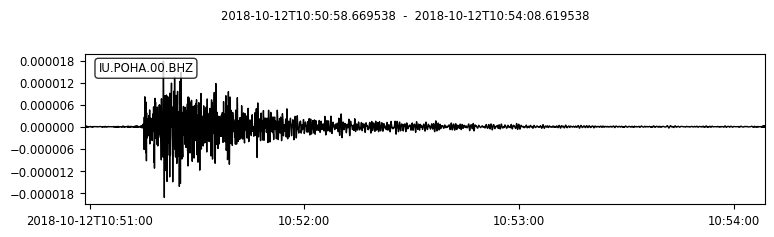

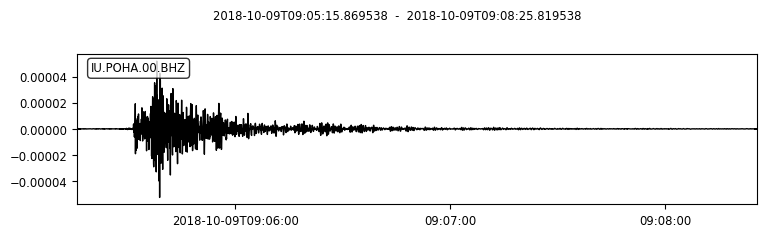

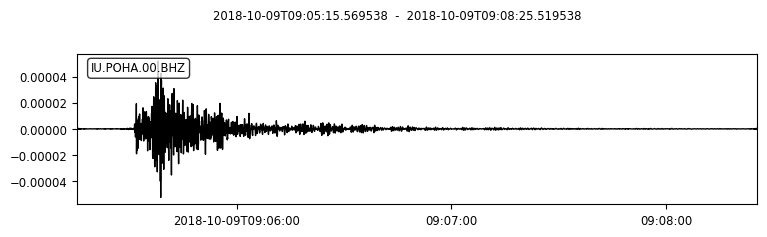

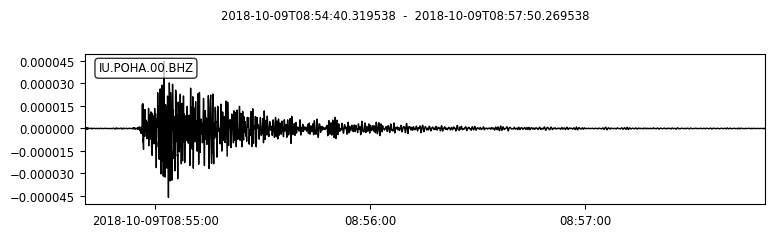

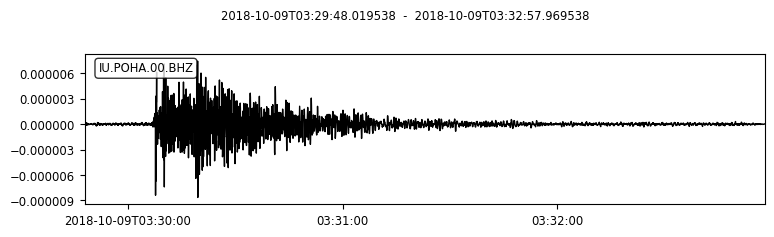

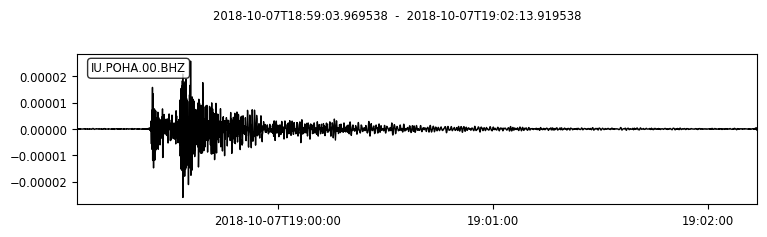

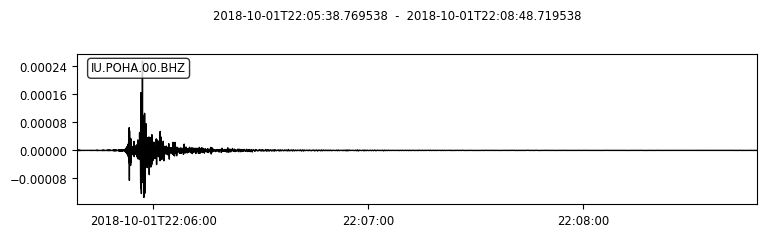

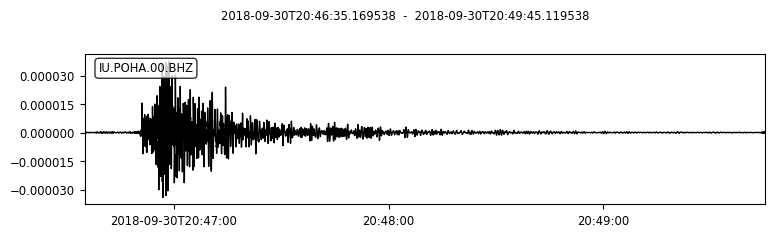

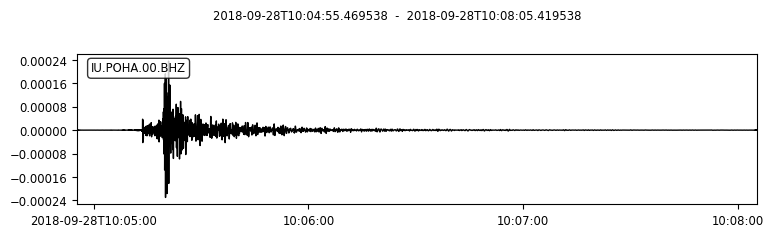

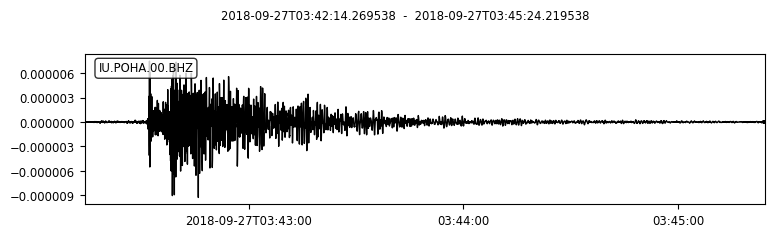

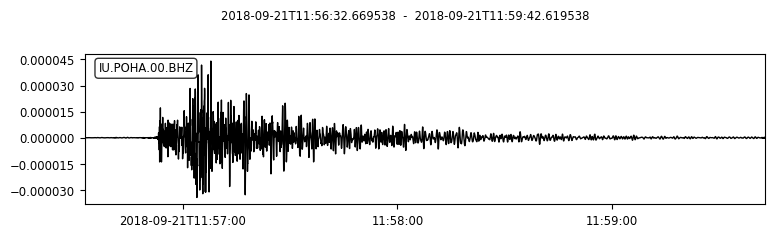

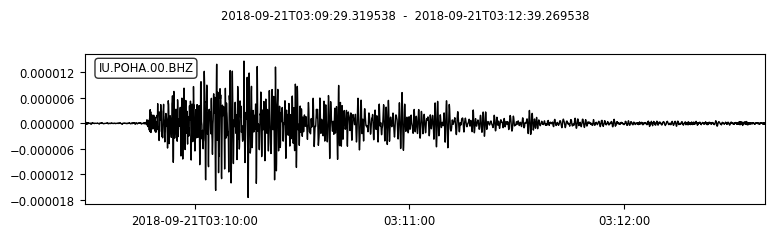

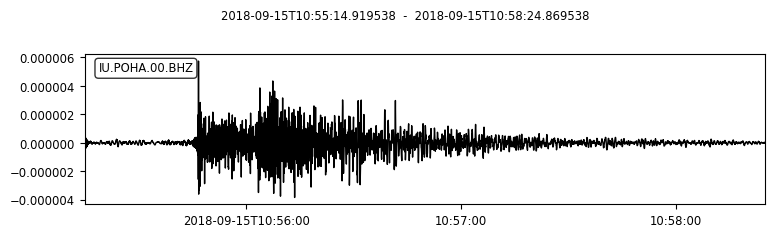

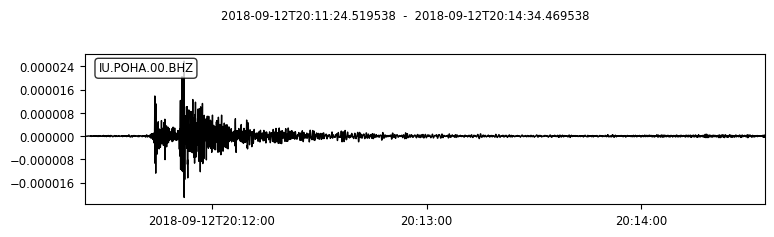

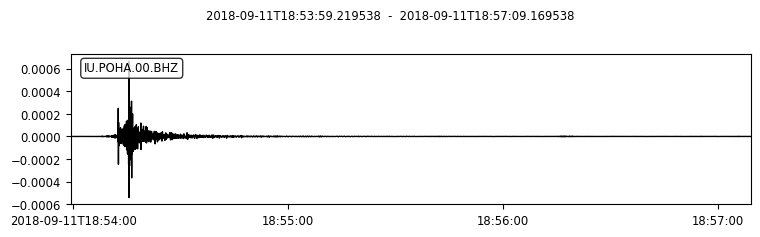

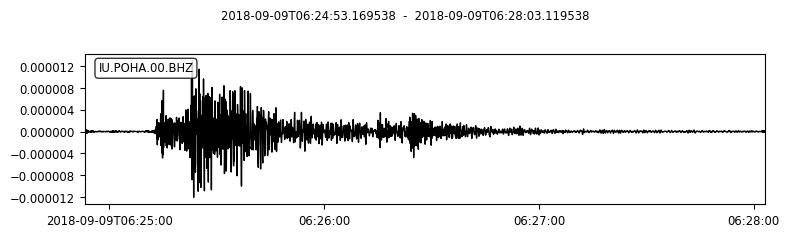

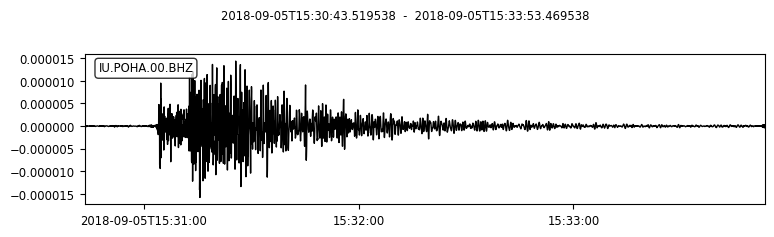

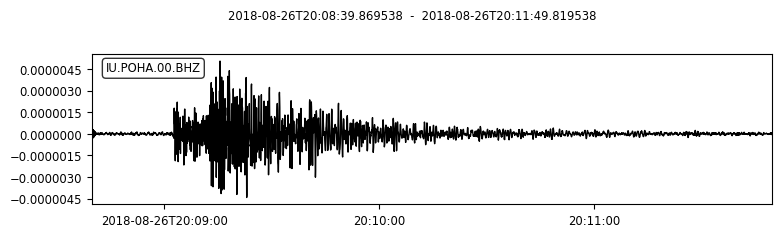

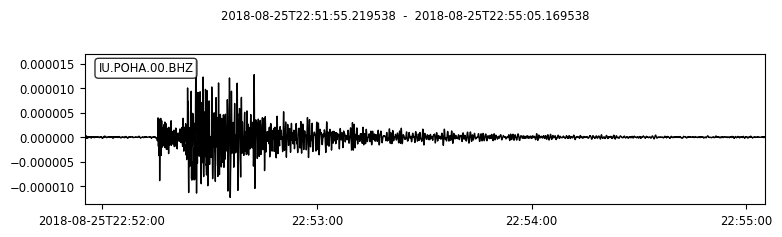

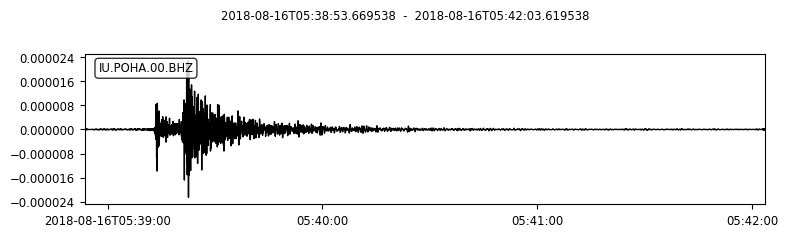

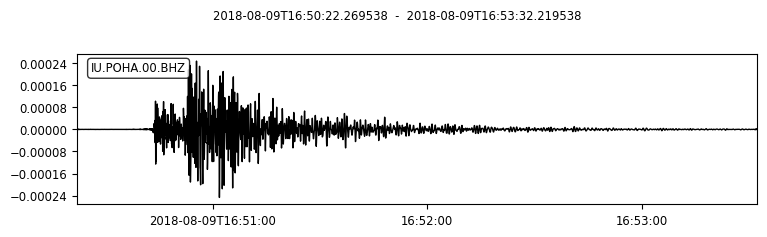

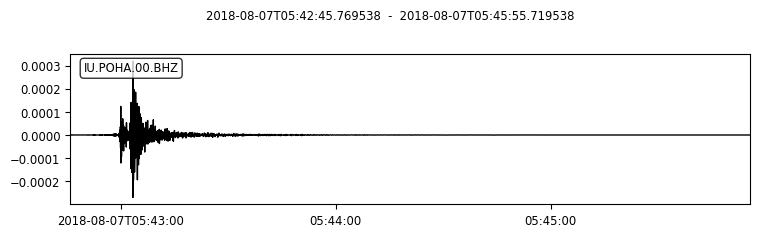

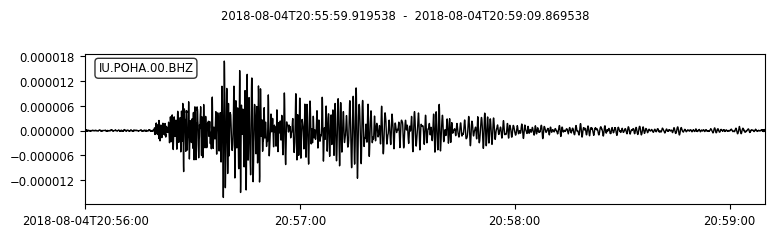

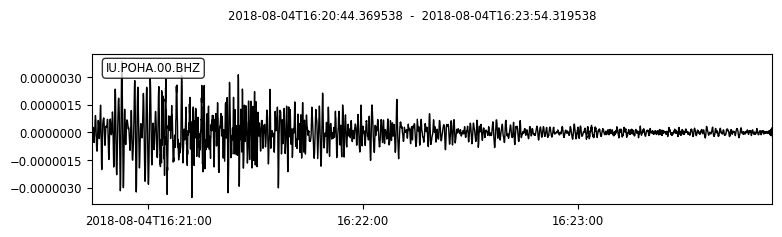

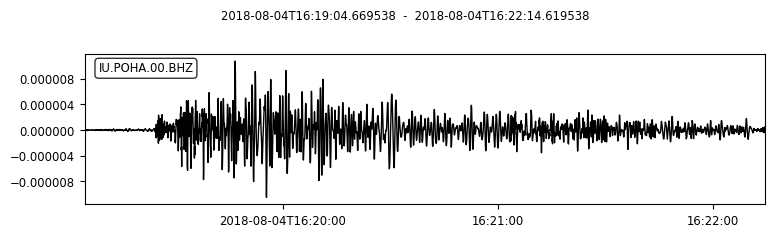

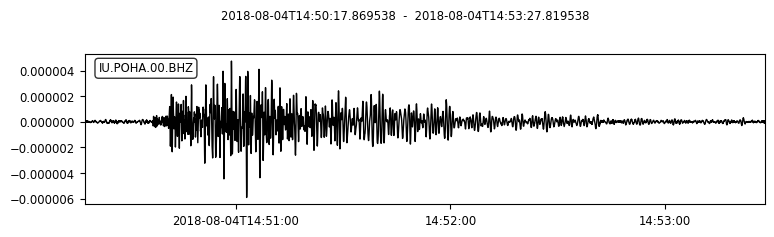

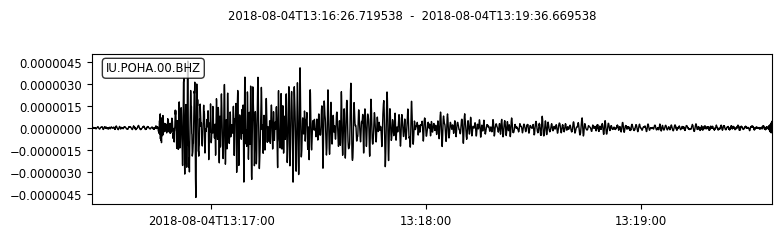

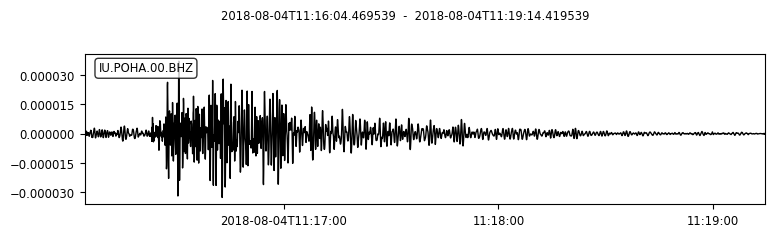

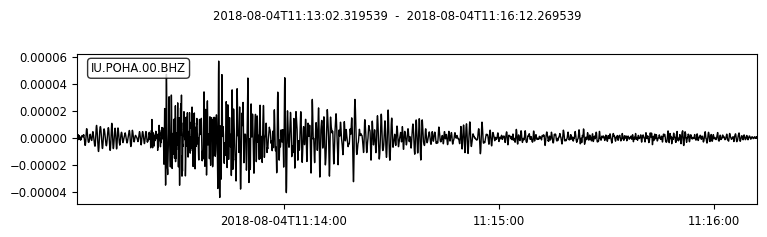

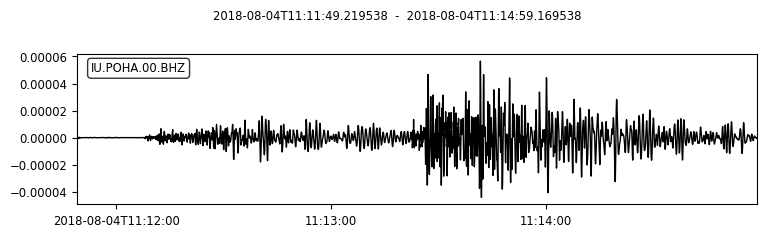

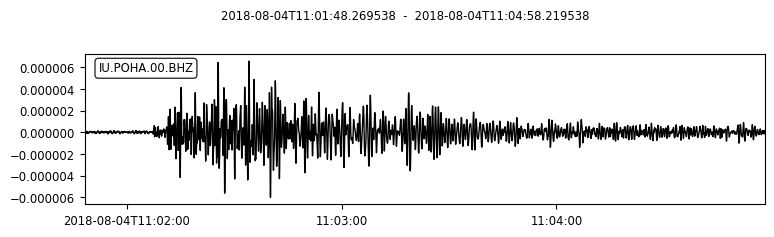

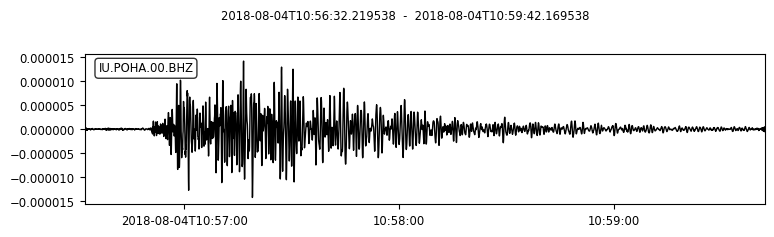

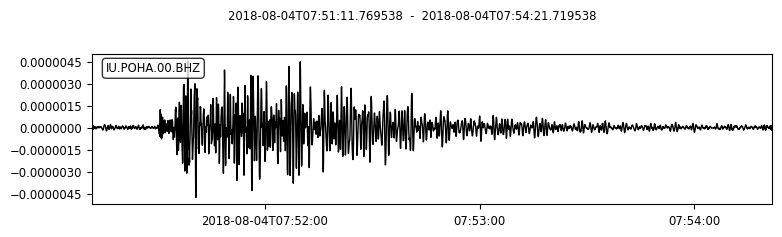

In [6]:
for i in range(50):
    #print(cat[i].magnitudes[0].mag)
    _ = quakestream[i].plot()
    

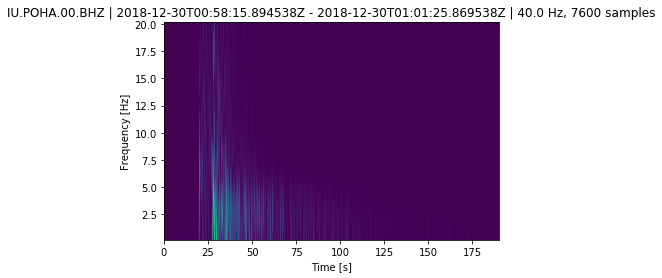

In [7]:
quakestream[0].spectrogram()

In [11]:
print("Seismogram info: {}".format(quakestream[0]))
print(cat[0])

Seismogram info: IU.POHA.00.BHZ | 2018-12-30T00:58:15.894538Z - 2018-12-30T01:01:25.869538Z | 40.0 Hz, 7600 samples
Event:	2018-12-30T00:58:25.890000Z | +19.337, -155.195 | 3.03 Ml

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=10990912")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=36425736")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=192095461")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements


In [ ]:
x = cat[0]

In [74]:
# find distance from epicenter to POHA to calculate the arrival time, and trim the time spectrogram
# Radius calculated from center ofearth

def sph_distance(r1, theta1, phi1, r2, theta2, phi2):
    return np.sqrt(r1**2 + r2**2 - 2*r1*r2*(np.sin(theta1)*np.sin(theta2) * np.cos(phi1-phi2) +
                                      np.cos(theta1)*np.cos(theta2)))

def deg2rad(deg):
    return deg*np.pi/180

def dist_from_POHA(depth, lat, long):
    # radius of earth
    r_e = 6378*1000 #meters
    POHA_theta = deg2rad(90 - POHA[0][0].latitude)
    POHA_phi = deg2rad(POHA[0][0].longitude)
    POHA_r = POHA[0][0].elevation + r_e
    #print(POHA_r)
    
    quake_r = r_e-depth
    #print(quake_r)
    
    return sph_distance(POHA_r, POHA_theta, POHA_phi, quake_r, deg2rad(90-lat), deg2rad(long))
    
    
     

In [75]:
dist_from_POHA(x.preferred_origin()['depth'], x.preferred_origin()['latitude'], x.preferred_origin()['longitude'])

59244.366934887781

## Trim seismograms to start at p wave arrival

### For now (7-7-2019) used automatic P-wave picking to trim the seismograms

In [4]:
import obspy.clients.iris

In [7]:
iris = obspy.clients.iris.Client()

In [15]:
ev = cat[0]
ev.origins[0]

6170.0

In [11]:
_.origins

[Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=36425736")
	          time: UTCDateTime(2018, 12, 30, 0, 58, 25, 890000)
	     longitude: -155.194667
	      latitude: 19.337
	         depth: 6170.0
	 creation_info: CreationInfo(author='hv,us')]

In [76]:
evdepth = ev.origins[0].depth/1000
evlat, evlong = ev.origins[0].latitude, ev.origins[0].longitude

coords = POHA.get_coordinates('IU.POHA.00.BHZ')

stalat, stalong = (coords['latitude'], coords['longitude'])

result = iris.traveltime(phases=['p'],evloc= evloc, staloc = staloc, evdepth=evdepth)

/Users/nate/anaconda/envs/seismic/lib/python3.7/site-packages/obspy/core/inventory/network.py:289: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


In [67]:
print(result.decode())

Model: iasp91
Distance   Depth   Phase   Travel    Ray Param  Takeoff  Incident  Purist    Purist
  (deg)     (km)   Name    Time (s)  p (s/deg)   (deg)    (deg)   Distance   Name 
-----------------------------------------------------------------------------------
    0.53     6.2   p         10.16    19.057     95.75    83.72     0.53   = p



In [42]:
evdepth

6.17

In [33]:
staloc

(-155.532593, 19.757299)

In [65]:
from obspy.taup import TauPyModel
taumodel = TauPyModel(model="iasp91")

In [69]:
z = taumodel.get_travel_times_geo(evdepth,evlat,evlong,stalat,stalong)

In [74]:
for i in z:
    print(i.time)

10.160366254
11.6058331744
17.5387058926
510.216964605
721.596615524
722.369134581
933.752133603
993.507424076
995.635009879
996.407526384
1204.88328333
1911.83554829
2123.21139505
2123.98391155
2335.35974247
2423.10194991
3270.92315168


In [75]:
z[0].time

10.160366253978983

In [77]:
evloc

(19.337, -155.194667)